# Contrastive Representation Learning for Predicting Solar Flares from Extremely Imbalanced Multivariate Time Series Data

CONTREX is a novel contrastive representation learning approach for multivariate time series data, addressing challenges of temporal dependencies and extreme class imbalance. Our method involves extracting dynamic features from the multivariate time series instances, deriving two extremes from positive and negative class feature vectors that provide maximum separation capability, and training a sequence representation embedding module with the original multivariate time series data guided by our custom contrastive reconstruction loss to generate embeddings aligned with the extreme points. These embeddings capture essential time series characteristics and enhance discriminative power. Our approach shows promising classification results on the SWAN-SF benchmark dataset against baseline methods.

### This module will allow a step by step guide to run all experiments in a single notebook file

# Downloading Partitions of Preprocessed SWAN-SF

In [2]:
import pycatch22 # package required for returning catch22 features out of time series
import pickle
import numpy as np
import os
import pandas as pd
from pathlib import Path

In [3]:
# Packages required
import os
import pandas as pd
from natsort import natsorted
from pathlib import Path

cur_dir = Path.cwd()
parent_folder = cur_dir.parent / 'DATA' / 'Preprocessed-SWANSF-main' 

# Defining the paths
folder_path_train = str(parent_folder) + '/train/'
folder_path_test = str(parent_folder) + '/test/'
print(folder_path_train)

# Extracting train and test partitions
X_train = []
y_train = []
num_partitions = 5

for i in range(num_partitions):
    with open(f"{folder_path_train}Partition{i+1}_RUS-Tomek-TimeGAN_LSBZM-Norm_WithoutC_FPCKNN-impute.pkl", 'rb') as f:
        X_train.append(pickle.load(f))
    with open(f"{folder_path_train}Partition{i+1}_Labels_RUS-Tomek-TimeGAN_LSBZM-Norm_WithoutC_FPCKNN-impute.pkl", 'rb') as f:
        y_train.append(pickle.load(f))
        
X_test = []
y_test = []
num_partitions = 5

for i in range(num_partitions):
    with open(f"{folder_path_test}Partition{i+1}_LSBZM-Norm_FPCKNN-impute.pkl", 'rb') as f:
        X_test.append(pickle.load(f))
    with open(f"{folder_path_test}Partition{i+1}_Labels_LSBZM-Norm_FPCKNN-impute.pkl", 'rb') as f:
        y_test.append(pickle.load(f))

C:\Users\user\Desktop\mvts-ss-anonym\DATA\Preprocessed-SWANSF-main/train/


In [4]:
SELECTED_PARTITION = 3
# Make list less deep 
X_train = X_train[SELECTED_PARTITION-1] 
y_train = y_train[SELECTED_PARTITION-1] 
X_test = X_test[SELECTED_PARTITION]
y_test = y_test[SELECTED_PARTITION] 
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(19965, 60, 24)
(19965,)
(51261, 60, 24)
(51261,)


# STEP 1: Extracting Catch22 features of solar flare data

In [5]:
import numpy as np

def get_catch22(ts_data_list, mvts_dimension, name):
    catch22_features = []
    for mvts in ts_data_list:
        instance_features = []
        for i in range(mvts_dimension):
            # Extracting Catch22 features for each univariate time series in MVTS data points
            univariate_ts = mvts[:, i]
            variable_features = pycatch22.catch22_all(univariate_ts) # catch22_all returns catch22 features out of time series
            values = variable_features['values']   
            values = np.nan_to_num(values, nan=0)
            instance_features.extend(values)
            
        catch22_features.append(instance_features)
    path = cur_dir.parent / 'DATA' / 'catch22' / name
    df_catch22 = pd.DataFrame(catch22_features)
    # Save to a CSV file
    df_catch22.to_csv(path, index=False)

    print(f"Saved Catch22 features to {path}")


In [6]:
partition_name = f'partition{SELECTED_PARTITION}_train'

get_catch22(X_train, 24, partition_name)

Saved Catch22 features to C:\Users\user\Desktop\mvts-ss-anonym\DATA\catch22\partition3_train


# The C22 Vectors

In [7]:
partition_name = f'partition{SELECTED_PARTITION}_train'
path = cur_dir.parent / 'DATA' / 'catch22' / partition_name
df_catch22 = pd.read_csv(path)
df_catch22

,0,1,2,3,4,5,6,7,8,9,...,518,519,520,521,522,523,524,525,526,527
0,-0.459607,-0.822260,0.872197,2.0,0.427136,-5.509315,0.627119,22.0,0.074074,8.0,...,0.133333,-0.825000,0.300000,0.898863,24.0,1.449367,0.769231,0.500000,0.098175,0.165275
1,0.508250,0.266761,1.480630,5.0,0.345880,0.355274,0.762712,9.0,0.074830,12.0,...,0.666667,-0.500000,0.900000,0.869762,6.0,1.751530,0.769231,0.230769,0.392699,0.627885
2,0.725704,0.523514,1.823803,2.0,0.245902,0.280024,0.796610,12.0,0.034014,2.0,...,0.076923,0.016667,0.733333,0.810624,16.0,1.800346,0.769231,0.769231,0.196350,0.575946
3,-0.131559,0.179578,2.834639,45.0,0.317384,-0.395133,0.322034,43.0,0.040000,0.0,...,1.000000,-0.650000,-0.933333,0.518899,52.0,1.365712,0.653846,0.423077,0.490874,0.670247
4,0.610353,0.790427,9.670908,32.0,0.854709,-0.209257,0.474576,30.0,0.166667,0.0,...,0.043478,-0.816667,0.641667,0.888562,28.0,1.342215,0.730769,0.653846,0.196350,0.407434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19960,1.125871,-1.370427,12.707835,37.0,1.009908,-0.164416,0.728814,29.0,0.166667,2.0,...,0.130435,0.566667,-0.950000,0.456250,4.0,1.342215,0.769231,0.230769,0.589049,0.545562
19961,0.750057,0.467648,3.963695,30.0,0.580410,-2.989459,0.288136,47.0,0.062500,0.0,...,1.333333,-0.916667,-0.500000,0.716941,9.0,1.299311,0.346154,0.692308,0.294524,0.488042
19962,0.663595,0.899269,0.714309,3.0,0.112158,0.730651,0.762712,8.0,0.003171,4.0,...,0.500000,-0.550000,0.416667,0.951290,13.0,1.481732,0.692308,0.538462,0.098175,0.252463
19963,0.247125,0.483499,3.388896,27.0,0.412113,0.105462,0.440678,42.0,0.062500,0.0,...,0.043478,-0.883333,0.666667,0.662880,14.0,1.417271,0.653846,0.615385,0.294524,0.351740


In [8]:
# Separate flare and nonflare objects
y_train_series = pd.Series(y_train)

# Separate df_catch22 into two DataFrames based on the labels
df_f_catch22 = df_catch22[y_train_series == 1].reset_index(drop=True)
df_nf_catch22 = df_catch22[y_train_series == 0].reset_index(drop=True)

# Print the shapes of the resulting DataFrames to verify
print(f"Shape of df_f_catch22: {df_f_catch22.shape}")
print(f"Shape of df_nf_catch22: {df_nf_catch22.shape}")

Shape of df_f_catch22: (9968, 528)
Shape of df_nf_catch22: (9997, 528)


In [9]:
df_f_catch22

,0,1,2,3,4,5,6,7,8,9,...,518,519,520,521,522,523,524,525,526,527
0,-0.459607,-0.822260,0.872197,2.0,0.427136,-5.509315,0.627119,22.0,0.074074,8.0,...,0.133333,-0.825000,0.300000,0.898863,24.0,1.449367,0.769231,0.500000,0.098175,0.165275
1,-0.131559,0.179578,2.834639,45.0,0.317384,-0.395133,0.322034,43.0,0.040000,0.0,...,1.000000,-0.650000,-0.933333,0.518899,52.0,1.365712,0.653846,0.423077,0.490874,0.670247
2,0.610353,0.790427,9.670908,32.0,0.854709,-0.209257,0.474576,30.0,0.166667,0.0,...,0.043478,-0.816667,0.641667,0.888562,28.0,1.342215,0.730769,0.653846,0.196350,0.407434
3,0.159185,-0.144288,1.615901,2.0,0.171614,-0.799288,0.271186,7.0,0.166667,2.0,...,1.000000,-0.933333,-0.666667,0.666733,7.0,1.365712,0.269231,0.461538,0.392699,0.614155
4,-0.661233,-0.885437,11.174014,4.0,0.808264,-0.055454,0.491525,24.0,0.166667,0.0,...,1.000000,0.566667,-0.916667,0.198669,13.0,1.622460,0.384615,0.269231,1.963495,0.419516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9963,-1.246072,-1.073774,11.477662,36.0,1.007735,-0.685474,0.762712,25.0,0.166667,3.0,...,0.052632,-0.933333,0.625000,0.655079,12.0,1.581496,0.423077,0.269231,0.294524,0.301328
9964,-0.098721,0.201782,2.957718,44.0,0.430242,-0.393113,0.338983,42.0,0.062500,0.0,...,1.000000,-0.633333,-0.950000,0.519269,52.0,1.365712,0.653846,0.423077,0.490874,0.650693
9965,1.125871,-1.370427,12.707835,37.0,1.009908,-0.164416,0.728814,29.0,0.166667,2.0,...,0.130435,0.566667,-0.950000,0.456250,4.0,1.342215,0.769231,0.230769,0.589049,0.545562
9966,0.750057,0.467648,3.963695,30.0,0.580410,-2.989459,0.288136,47.0,0.062500,0.0,...,1.333333,-0.916667,-0.500000,0.716941,9.0,1.299311,0.346154,0.692308,0.294524,0.488042


In [10]:
df_nf_catch22

,0,1,2,3,4,5,6,7,8,9,...,518,519,520,521,522,523,524,525,526,527
0,0.508250,0.266761,1.480630,5.0,0.345880,0.355274,0.762712,9.0,0.074830,12.0,...,0.666667,-0.500000,0.900000,0.869762,6.0,1.751530,0.769231,0.230769,0.392699,0.627885
1,0.725704,0.523514,1.823803,2.0,0.245902,0.280024,0.796610,12.0,0.034014,2.0,...,0.076923,0.016667,0.733333,0.810624,16.0,1.800346,0.769231,0.769231,0.196350,0.575946
2,0.792585,0.967479,5.316209,14.0,0.276395,0.250261,0.932203,17.0,0.047619,4.0,...,0.052632,0.300000,-0.833333,0.736979,6.0,1.814931,0.615385,0.461538,0.098175,0.619535
3,0.233839,0.407307,1.040943,2.0,0.290127,-0.195413,0.610169,31.0,0.111111,6.0,...,0.538462,-0.316667,0.616667,0.923996,6.0,1.594446,0.538462,0.769231,0.098175,0.452114
4,-0.306363,-0.037597,1.244875,7.0,0.236442,-0.433313,0.796610,9.0,0.040816,0.0,...,0.100000,-0.325000,0.716667,0.390824,5.0,1.773327,0.653846,0.769231,0.687223,1.079508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9992,-0.133650,0.524389,1.622929,6.0,0.518866,0.314446,0.610169,12.0,0.046296,3.0,...,0.055556,-0.283333,0.733333,0.896057,5.0,1.417271,0.769231,0.769231,0.098175,0.379460
9993,0.712542,0.126904,7.449588,16.0,0.496199,0.025098,0.847458,29.0,0.074074,14.0,...,0.045455,-0.816667,0.700000,0.940124,11.0,1.417271,0.769231,0.461538,0.098175,0.132334
9994,0.836355,0.624687,7.156421,5.0,0.427466,0.559472,0.881356,32.0,0.166667,5.0,...,0.285714,0.766667,0.000000,0.947040,5.0,1.521975,0.769231,0.769231,0.098175,0.243079
9995,0.663595,0.899269,0.714309,3.0,0.112158,0.730651,0.762712,8.0,0.003171,4.0,...,0.500000,-0.550000,0.416667,0.951290,13.0,1.481732,0.692308,0.538462,0.098175,0.252463


# STEP 2: Finding the extreme points

In [11]:
from scipy.spatial import distance

max_distance = float('-inf')
max_vec_positive = None
max_vec_negative = None
# Finds the complete linkage between two clusters: flare-positive and flare-negatives.
for index_pos, row_pos in df_f_catch22.iterrows():
    for index_neg, row_neg in df_nf_catch22.iterrows():
        dist = distance.euclidean(row_pos.values, row_neg.values) # The distance is euclidian distance
        if dist > max_distance:
            max_distance = dist
            max_vec_positive = row_pos.values
            max_vec_negative = row_neg.values

print("Positive Vector:", max_vec_positive)
print("Negative Vector:", max_vec_negative)
print("Max Pair Euclidean Distance:", max_distance)

Positive Vector: [-2.66994586e-01  6.94869007e-02  2.57697478e+00  4.80000000e+01
  5.89365586e-01 -5.70597819e-01  2.88135593e-01  4.40000000e+01
  6.25000000e-02  0.00000000e+00  1.85788357e-01  7.00000000e+00
  2.14285714e-01  3.16666667e-01 -8.16666667e-01  6.32601623e-01
  3.00000000e+00  1.29931079e+00  3.07692308e-01  5.00000000e-01
  2.94524311e-01  6.95303656e-01  2.73659670e-01  5.29585649e-01
  6.13093130e+00  4.40000000e+01  5.97496306e-01 -1.44504795e-01
  3.89830508e-01  4.00000000e+01  7.40740741e-02  0.00000000e+00
  1.49133211e-01  3.00000000e+00  1.11111111e-01  4.33333333e-01
 -7.83333333e-01  7.60306395e-01  4.00000000e+00  1.36571162e+00
  3.46153846e-01  5.76923077e-01  1.96349541e-01  6.24933718e-01
 -5.91742421e-01 -1.63192151e-01  7.28075060e-01  2.00000000e+00
  3.88186638e-01  7.15842120e+00  1.52542373e-01  2.90000000e+01
  6.14347998e-02  0.00000000e+00  3.51121639e-02  3.00000000e+00
  1.00000000e+00 -8.83333333e-01 -5.50000000e-01  1.80694219e-01
  9.0000

In [12]:
# Save the extreme points
centroid_name = f'centroids_partition{SELECTED_PARTITION}'
path = cur_dir.parent / 'DATA' / 'catch22' / centroid_name
centroid_df = pd.DataFrame([max_vec_positive, max_vec_negative])
centroid_df.to_csv(path, index=False)

In [13]:
# Display the extreme points
df_extremes = pd.read_csv(path)
df_extremes

,0,1,2,3,4,5,6,7,8,9,...,518,519,520,521,522,523,524,525,526,527
0,-0.266995,0.069487,2.576975,48.0,0.589366,-0.570598,0.288136,44.0,0.06250,0.0,...,0.8,-0.70,-0.933333,0.541483,54.0,1.299311,0.269231,0.230769,0.490874,0.713558
1,0.481920,0.212951,1.831776,6.0,0.115056,0.139004,0.966102,8.0,0.00551,13.0,...,0.5,-0.15,-0.900000,0.181345,4.0,2.004062,0.769231,0.461538,1.472622,1.125874


# STEP 3: Training the framework

* # Sequence representation embedding module

In [15]:
import torch
import torch.nn as nn

class Sequence_Representation_Embedding(nn.Module):
    # input_size = N = Number of univariate time series in MVTS = Magnetic Field Paramaetes
    def __init__(self, input_size=24, hidden_size=128, output_size=528):
        super(Sequence_Representation_Embedding, self).__init__()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size)
        
        # MLP Projection Layer
        self.fc = nn.Linear(hidden_size, output_size)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        
        # Apply dropout
        lstm_out = self.dropout(lstm_out)
        
        # MLP Head
        mlp_out = self.fc(lstm_out[:, -1, :])  # Taking the last hidden layer from LSTM
        
        return mlp_out

model = Sequence_Representation_Embedding()
print(model)

Sequence_Representation_Embedding(
  (lstm): LSTM(24, 128)
  (fc): Linear(in_features=128, out_features=528, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


* # Contrastive reconstruction loss

In [16]:
# Our custom reconstruction loss function
# When we have positive class instance, the loss will be calculated with the positive extreme
# When we have negative class instance, the loss will be calculated with the negative extreme
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class CustomLoss(nn.Module):
    def __init__(self, positive_extreme, negative_extreme):
        super(CustomLoss, self).__init__()
        self.positive_extreme = positive_extreme
        self.negative_extreme = negative_extreme
        
    def forward(self, outputs, labels):
        # Compute MSE loss based on the label information
        positive_mask = labels == 1  # label 1 corresponds to postive
        negative_mask = ~positive_mask
        
        if positive_mask.any():
            positive_loss = torch.mean((outputs[positive_mask] - self.positive_extreme) ** 2)
        else:
            positive_loss = 0.0
        
        if negative_mask.any():
            negative_loss = torch.mean((outputs[negative_mask] - self.negative_extreme) ** 2)
        else:
            negative_loss = 0.0
        
        loss = positive_loss + negative_loss
        return loss


In [17]:
# Get the extremes
centroid_name = f'centroids_partition{SELECTED_PARTITION}'
path = cur_dir.parent / 'DATA' / 'catch22' / centroid_name
df_extremes = pd.read_csv(path)

#mean_positive_centroid = positive_centroid_selected
#mean_negative_centroid = negative_centroid_selected
positive_extreme = df_extremes.iloc[0].to_numpy()
negative_extreme = df_extremes.iloc[1].to_numpy()

* # Training of Sequence Representation Embedding

In [18]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Model is ready
model = Sequence_Representation_Embedding()

# Define positive and negative extremes
positive_extreme_tensor = torch.tensor(positive_extreme, dtype=torch.float32)
negative_extreme_tensor = torch.tensor(negative_extreme, dtype=torch.float32)

# Instantiating the custom loss function
criterion = CustomLoss(positive_extreme_tensor, negative_extreme_tensor)

# Adam optimizer, lr = 10-2
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Track loss
        running_loss += loss.item() * inputs.size(0)
    
    # Print epoch loss
    epoch_loss = running_loss / len(dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [1/20], Loss: 65.1500
Epoch [2/20], Loss: 33.0342
Epoch [3/20], Loss: 27.8035
Epoch [4/20], Loss: 26.7537
Epoch [5/20], Loss: 25.5250
Epoch [6/20], Loss: 25.5378
Epoch [7/20], Loss: 24.8558
Epoch [8/20], Loss: 24.7688
Epoch [9/20], Loss: 24.5320
Epoch [10/20], Loss: 24.1737
Epoch [11/20], Loss: 24.0125
Epoch [12/20], Loss: 23.9446
Epoch [13/20], Loss: 23.6055
Epoch [14/20], Loss: 24.1760
Epoch [15/20], Loss: 23.6855
Epoch [16/20], Loss: 23.4367
Epoch [17/20], Loss: 23.6792
Epoch [18/20], Loss: 23.4554
Epoch [19/20], Loss: 23.4667
Epoch [20/20], Loss: 23.5395


In [19]:
def extract_embeddings(model, dataloader):
    embeddings = []
    my_labels = []
    with torch.no_grad():
        model.eval()  # Set model to evaluation mode
        for inputs, labels in dataloader:
            outputs = model(inputs)
            embeddings.append(outputs)
            my_labels.append(labels)
    return torch.cat(embeddings, dim=0), torch.cat(my_labels, dim=0)

In [20]:
# Extract the embeddings with trained values    
embeddings, my_labels = extract_embeddings(model, dataloader)
print(embeddings.shape)
print(my_labels.shape)

torch.Size([19965, 528])
torch.Size([19965])


In [21]:
print(embeddings)
print(my_labels)

tensor([[ 0.3493,  0.2067,  1.9665,  ...,  0.4673,  1.3110,  1.2131],
        [ 0.2163,  0.1616,  2.0994,  ...,  0.4010,  1.1557,  1.1503],
        [-0.2268,  0.0671,  2.5409,  ...,  0.2615,  0.5806,  0.9053],
        ...,
        [ 0.2992,  0.1807,  2.0172,  ...,  0.4304,  1.2629,  1.2050],
        [-0.2352,  0.0652,  2.5492,  ...,  0.2588,  0.5702,  0.9013],
        [-0.2287,  0.0668,  2.5427,  ...,  0.2612,  0.5787,  0.9052]])
tensor([0., 0., 1.,  ..., 0., 1., 1.])


* # Visualizing the embeddings with TSNE

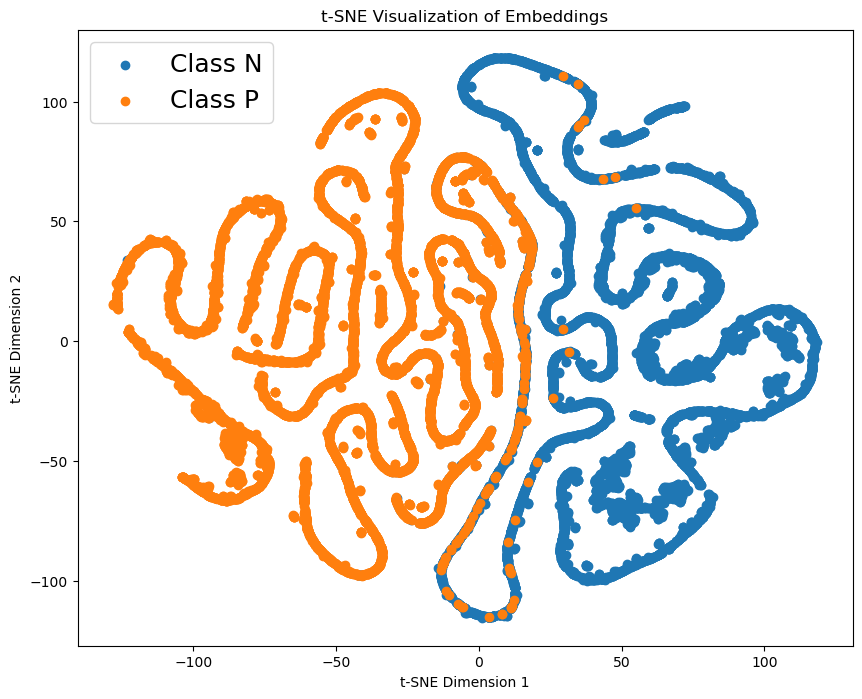

In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
def visualize_embeddings(embeddings, labels, extremes=None, save_path=None):
    # Separate flare and nonflare embeddings
    flare_indices = np.where(labels == 1)[0]
    nonflare_indices = np.where(labels == 0)[0]
    
    # Combine flare and sampled nonflare indices
    combined_indices = np.concatenate([flare_indices, nonflare_indices])
    
    # Get embeddings and corresponding labels for selected indices
    selected_embeddings = embeddings[combined_indices]
    selected_labels = labels[combined_indices]
    
    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(selected_embeddings)
    
    # Plot embeddings
    plt.figure(figsize=(10, 8))
    for label in np.unique(selected_labels):
        indices = np.where(selected_labels == label)[0]
        if label == 1:
            plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], label='Class P')
        else:
            plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], label='Class N')
    
    # Plot extremes if provided
    if extremes is not None:
        plt.scatter(extremes[0, 0], extremes[0, 1], marker='o', color='red', label='Positive Extreme')
        plt.scatter(extremes[1, 0], extremes[1, 1], marker='o', color='blue', label='Negative Extreme')
    
    plt.title('t-SNE Visualization of Embeddings')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(fontsize=18)
    
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

save_path = cur_dir / 'tSNE_visualization.png'
# Visualize embeddings 
visualize_embeddings(embeddings.numpy(), my_labels.numpy(), extremes=None, save_path=save_path)

* # Training downstream classifiers with our embeddings

In [23]:
import torch
import numpy as np

if isinstance(embeddings, torch.Tensor):
    embeddings = embeddings.numpy()
    print(embeddings)

if isinstance(my_labels, torch.Tensor):
    my_labels = my_labels.numpy()
    print(my_labels)

[[ 0.34931514  0.2066887   1.966544   ...  0.46731073  1.3110476
   1.2130867 ]
 [ 0.21633503  0.1615868   2.099416   ...  0.4009933   1.1556756
   1.1502945 ]
 [-0.22684902  0.06709825  2.540853   ...  0.26152906  0.58059174
   0.90526426]
 ...
 [ 0.29915178  0.18068807  2.0172336  ...  0.4303845   1.2629
   1.2049608 ]
 [-0.23515737  0.06519386  2.5491817  ...  0.25881946  0.5702493
   0.90130734]
 [-0.228683    0.06680191  2.5427325  ...  0.2611857   0.57873577
   0.90516955]]
[0. 0. 1. ... 0. 1. 1.]


In [24]:
from sklearn.linear_model import LogisticRegression
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(embeddings, my_labels)

LogisticRegression(max_iter=1000)

In [25]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(embeddings, my_labels)

KNeighborsClassifier()

In [26]:
from sklearn.neural_network import MLPClassifier
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp_model.fit(embeddings, my_labels)

MLPClassifier(max_iter=500, random_state=42)

In [27]:
from sklearn.svm import SVC
svm_model = SVC()
svm_model.fit(embeddings, my_labels)

SVC()

In [28]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(embeddings, my_labels)

DecisionTreeClassifier(random_state=42)

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# After training the sequence model and obtaining the seq embeddings, use those to train a fully connected network

# Define FCN for classification
class FCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Add dropout for regularization

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return torch.sigmoid(x) 

# Define dataset and dataloader for training FCN
# Assuming you have extracted embeddings and corresponding labels
X_train_tensor = torch.tensor(embeddings, dtype=torch.float32)  # embeddings obtained from LSTM
y_train_tensor = torch.tensor(my_labels, dtype=torch.float32)  # labels (0 for non-flare, 1 for flare)


dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Instantiate the FCN model
input_dim = embeddings.shape[1]  # Dimension of the LSTM embeddings
print(input_dim)
hidden_dim = 256  # Adjust as needed
output_dim = 1  # Binary classification (flare or non-flare)
fcn_model = FCN(input_dim, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(fcn_model.parameters(), lr=0.001, weight_decay=0.01)

# Train the FCN model
num_epochs = 20
for epoch in range(num_epochs):
    fcn_model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for inputs, labels in dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = fcn_model(inputs)
        # Compute loss
        loss = criterion(outputs, labels.unsqueeze(1).float())
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Track loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        predicted = (outputs >= 0.5).float()
        correct_predictions += (predicted == labels.unsqueeze(1)).sum().item()  
        total_samples += labels.size(0)
    
    # Print epoch statistics
    epoch_loss = running_loss / total_samples
    accuracy = correct_predictions / total_samples
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}')

528
Epoch [1/20], Loss: 0.1473, Accuracy: 0.9564
Epoch [2/20], Loss: 0.1280, Accuracy: 0.9618
Epoch [3/20], Loss: 0.1318, Accuracy: 0.9611
Epoch [4/20], Loss: 0.1305, Accuracy: 0.9622
Epoch [5/20], Loss: 0.1320, Accuracy: 0.9613
Epoch [6/20], Loss: 0.1311, Accuracy: 0.9625
Epoch [7/20], Loss: 0.1314, Accuracy: 0.9609
Epoch [8/20], Loss: 0.1310, Accuracy: 0.9619
Epoch [9/20], Loss: 0.1353, Accuracy: 0.9601
Epoch [10/20], Loss: 0.1320, Accuracy: 0.9608
Epoch [11/20], Loss: 0.1325, Accuracy: 0.9606
Epoch [12/20], Loss: 0.1367, Accuracy: 0.9607
Epoch [13/20], Loss: 0.1295, Accuracy: 0.9626
Epoch [14/20], Loss: 0.1307, Accuracy: 0.9642
Epoch [15/20], Loss: 0.1324, Accuracy: 0.9623
Epoch [16/20], Loss: 0.1356, Accuracy: 0.9601
Epoch [17/20], Loss: 0.1326, Accuracy: 0.9611
Epoch [18/20], Loss: 0.1312, Accuracy: 0.9612
Epoch [19/20], Loss: 0.1340, Accuracy: 0.9605
Epoch [20/20], Loss: 0.1358, Accuracy: 0.9607


# STEP 4: Test Phase / Binary Solar Flare Prediction Performance Results
* First get embeddings, then use it to feed trained models

In [30]:
# Convert test data to PyTorch tensor
test_data_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define dataset and dataloader
dataset = TensorDataset(test_data_tensor, y_test_tensor)
test_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Forward pass through the sequence model
with torch.no_grad():
    model.eval()  # Set model to evaluation mode
    sequence_embeddings = []
    my_test_labels = []
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        sequence_embeddings.append(outputs)
        my_test_labels.append(labels)
    sequence_embeddings = torch.cat(sequence_embeddings, dim=0)
    my_test_labels = torch.cat(my_test_labels, dim=0)
    

In [31]:
print(sequence_embeddings.shape)
print(my_test_labels.shape)

torch.Size([51261, 528])
torch.Size([51261])


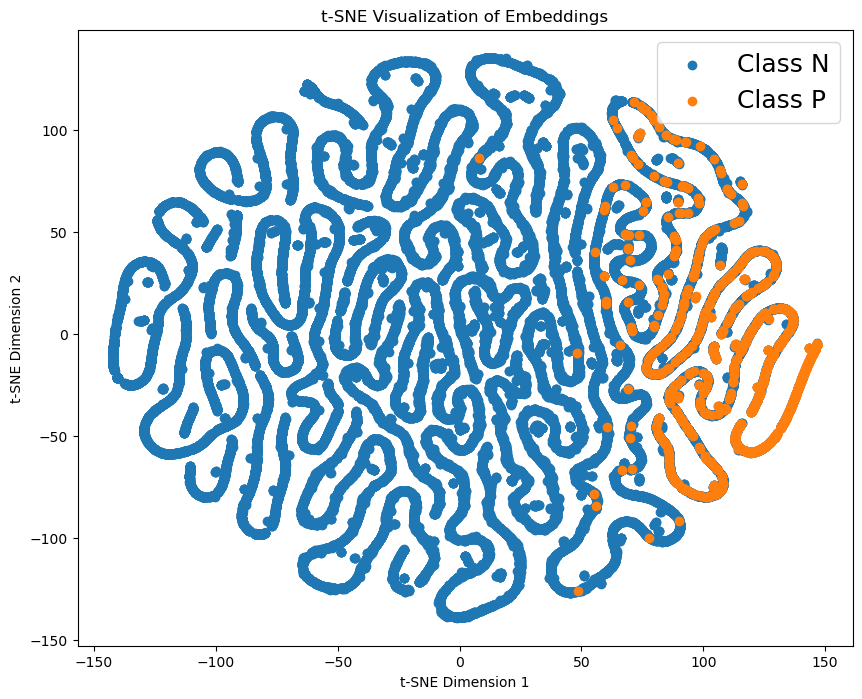

In [32]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
def visualize_embeddings(embeddings, labels, centroids=None, save_path=None):
    # Separate flare and nonflare embeddings
    flare_indices = np.where(labels == 1)[0]
    nonflare_indices = np.where(labels == 0)[0]
    
    # Combine flare and sampled nonflare indices
    combined_indices = np.concatenate([flare_indices, nonflare_indices])
    
    # Get embeddings and corresponding labels for selected indices
    selected_embeddings = embeddings[combined_indices]
    selected_labels = labels[combined_indices]
    
    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(selected_embeddings)
    
    # Plot embeddings
    plt.figure(figsize=(10, 8))
    for label in np.unique(selected_labels):
        indices = np.where(selected_labels == label)[0]
        if label == 1:
            plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], label='Class P')
        else:
            plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], label='Class N')
    
    plt.title('t-SNE Visualization of Embeddings')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(fontsize=18)
    
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

save_path = cur_dir / 'tSNE_test_visualization.png'
# Visualize embeddings 
visualize_embeddings(sequence_embeddings.numpy(), my_test_labels.numpy(), centroids=None, save_path=save_path)

* # Test downstream classifiers

In [33]:
if isinstance(sequence_embeddings, torch.Tensor):
    sequence_embeddings = sequence_embeddings.numpy()
    print(sequence_embeddings)

if isinstance(my_test_labels, torch.Tensor):
    my_test_labels = my_test_labels.numpy()
    print(my_test_labels)

[[-0.15462032  0.07109361  2.4679255  ...  0.31121504  0.6507282
   0.9031146 ]
 [-0.03290042  0.1103741   2.3474836  ...  0.3252632   0.833595
   1.0121796 ]
 [ 0.1608614   0.15161672  2.1548517  ...  0.38691673  1.0837643
   1.1264532 ]
 ...
 [ 0.30190057  0.18130547  2.014495   ...  0.4313144   1.2664378
   1.2065464 ]
 [ 0.3011623   0.18114229  2.0152304  ...  0.43106997  1.2654921
   1.2061304 ]
 [ 0.20608106  0.16180074  2.1098745  ...  0.402432    1.1430027
   1.1538837 ]]
[0. 0. 0. ... 0. 0. 0.]


In [40]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score
y_pred = logreg_model.predict(sequence_embeddings)

conf_matrix = confusion_matrix(my_test_labels, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
print("tn, fp, fn, tp", tn, fp, fn, tp)

# Calculate Accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Calculate True Skill Statistics (TSS)
tss = (tp / (tp + fn)) - (fp / (fp + tn))

# Calculate Heidke Skill Score 2 (HSS2)
hss2 = (2 * (tp * tn - fp * fn)) / ((tp + fn) * (tn + fn) + (tp + fp) * (tn + fp))

# Calculate F1 Score
f1 = f1_score(my_test_labels, y_pred)

# Calculate Gilbert Skill Score
gilbert = (tp - (tp + fn) * (tp + fp) / (tp + tn + fp + fn)) / (tp + tn - (tp + fn) * (tp + fp) / (tp + tn + fp + fn))

# Calculate ROC AUC score
roc_auc = roc_auc_score(my_test_labels, y_pred)

print("LR Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("True Skill Statistics (TSS):", tss)
print("Heidke Skill Score 2 (HSS2):", hss2)
print("F1 Score:", f1)
print("Gilbert Skill Score:", gilbert)
print("ROC AUC Score:", roc_auc)
print("********************************************")

tn, fp, fn, tp 39199 10897 4 1161
LR Model Evaluation Metrics:
Accuracy: 0.7873432043854002
True Skill Statistics (TSS): 0.779044166530733
Heidke Skill Score 2 (HSS2): 0.13995510925759527
F1 Score: 0.1756031157831052
Gilbert Skill Score: 0.02212644761246606
ROC AUC Score: 0.8895220832653665
********************************************


In [35]:
y_pred = knn_model.predict(sequence_embeddings)

conf_matrix = confusion_matrix(my_test_labels, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
print("tn, fp, fn, tp", tn, fp, fn, tp)

# Calculate Accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Calculate True Skill Statistics (TSS)
tss = (tp / (tp + fn)) - (fp / (fp + tn))

# Calculate Heidke Skill Score 2 (HSS2)
hss2 = (2 * (tp * tn - fp * fn)) / ((tp + fn) * (tn + fn) + (tp + fp) * (tn + fp))

# Calculate F1 Score
f1 = f1_score(my_test_labels, y_pred)

# Calculate Gilbert Skill Score
gilbert = (tp - (tp + fn) * (tp + fp) / (tp + tn + fp + fn)) / (tp + tn - (tp + fn) * (tp + fp) / (tp + tn + fp + fn))

# Calculate ROC AUC score
roc_auc = roc_auc_score(my_test_labels, y_pred)

print("KNN Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("True Skill Statistics (TSS):", tss)
print("Heidke Skill Score 2 (HSS2):", hss2)
print("F1 Score:", f1)
print("Gilbert Skill Score:", gilbert)
print("ROC AUC Score:", roc_auc)
print("********************************************")

tn, fp, fn, tp 40634 9462 10 1155
KNN Model Evaluation Metrics:
Accuracy: 0.815220147870701
True Skill Statistics (TSS): 0.8025389535353924
Heidke Skill Score 2 (HSS2): 0.16172677420876574
F1 Score: 0.1960617891699202
Gilbert Skill Score: 0.02199180819072409
ROC AUC Score: 0.9012694767676963
********************************************


In [36]:
y_pred = mlp_model.predict(sequence_embeddings)

conf_matrix = confusion_matrix(my_test_labels, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
print("tn, fp, fn, tp", tn, fp, fn, tp)

# Calculate Accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Calculate True Skill Statistics (TSS)
tss = (tp / (tp + fn)) - (fp / (fp + tn))

# Calculate Heidke Skill Score 2 (HSS2)
hss2 = (2 * (tp * tn - fp * fn)) / ((tp + fn) * (tn + fn) + (tp + fp) * (tn + fp))

# Calculate F1 Score
f1 = f1_score(my_test_labels, y_pred)

# Calculate Gilbert Skill Score
gilbert = (tp - (tp + fn) * (tp + fp) / (tp + tn + fp + fn)) / (tp + tn - (tp + fn) * (tp + fp) / (tp + tn + fp + fn))

# Calculate ROC AUC score
roc_auc = roc_auc_score(my_test_labels, y_pred)

print("MLP Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("True Skill Statistics (TSS):", tss)
print("Heidke Skill Score 2 (HSS2):", hss2)
print("F1 Score:", f1)
print("Gilbert Skill Score:", gilbert)
print("ROC AUC Score:", roc_auc)
print("********************************************")

tn, fp, fn, tp 37732 12364 2 1163
MLP Model Evaluation Metrics:
Accuracy: 0.7587639726107567
True Skill Statistics (TSS): 0.7514771295764493
Heidke Skill Score 2 (HSS2): 0.1215550418902792
F1 Score: 0.15831745167438063
Gilbert Skill Score: 0.02217227170661929
ROC AUC Score: 0.8757385647882245
********************************************


In [37]:
y_pred = svm_model.predict(sequence_embeddings)

conf_matrix = confusion_matrix(my_test_labels, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
print("tn, fp, fn, tp", tn, fp, fn, tp)

# Calculate Accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Calculate True Skill Statistics (TSS)
tss = (tp / (tp + fn)) - (fp / (fp + tn))

# Calculate Heidke Skill Score 2 (HSS2)
hss2 = (2 * (tp * tn - fp * fn)) / ((tp + fn) * (tn + fn) + (tp + fp) * (tn + fp))

# Calculate F1 Score
f1 = f1_score(my_test_labels, y_pred)

# Calculate Gilbert Skill Score
gilbert = (tp - (tp + fn) * (tp + fp) / (tp + tn + fp + fn)) / (tp + tn - (tp + fn) * (tp + fp) / (tp + tn + fp + fn))

# Calculate ROC AUC score
roc_auc = roc_auc_score(my_test_labels, y_pred)

print("SVM Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("True Skill Statistics (TSS):", tss)
print("Heidke Skill Score 2 (HSS2):", hss2)
print("F1 Score:", f1)
print("Gilbert Skill Score:", gilbert)
print("ROC AUC Score:", roc_auc)
print("********************************************")

tn, fp, fn, tp 38278 11818 2 1163
SVM Model Evaluation Metrics:
Accuracy: 0.7694153449991221
True Skill Statistics (TSS): 0.7623762033547948
Heidke Skill Score 2 (HSS2): 0.12805919171575428
F1 Score: 0.16442810688533863
Gilbert Skill Score: 0.022172978193226934
ROC AUC Score: 0.8811881016773974
********************************************


In [38]:
y_pred = dt_model.predict(sequence_embeddings)

conf_matrix = confusion_matrix(my_test_labels, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
print("tn, fp, fn, tp", tn, fp, fn, tp)

# Calculate Accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Calculate True Skill Statistics (TSS)
tss = (tp / (tp + fn)) - (fp / (fp + tn))

# Calculate Heidke Skill Score 2 (HSS2)
hss2 = (2 * (tp * tn - fp * fn)) / ((tp + fn) * (tn + fn) + (tp + fp) * (tn + fp))

# Calculate F1 Score
f1 = f1_score(my_test_labels, y_pred)

# Calculate Gilbert Skill Score
gilbert = (tp - (tp + fn) * (tp + fp) / (tp + tn + fp + fn)) / (tp + tn - (tp + fn) * (tp + fp) / (tp + tn + fp + fn))

# Calculate ROC AUC score
roc_auc = roc_auc_score(my_test_labels, y_pred)

print("DT Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("True Skill Statistics (TSS):", tss)
print("Heidke Skill Score 2 (HSS2):", hss2)
print("F1 Score:", f1)
print("Gilbert Skill Score:", gilbert)
print("ROC AUC Score:", roc_auc)
print("********************************************")

tn, fp, fn, tp 41048 9048 76 1089
DT Model Evaluation Metrics:
Accuracy: 0.8220089346676811
True Skill Statistics (TSS): 0.7541507258852702
Heidke Skill Score 2 (HSS2): 0.1583985645240485
F1 Score: 0.1927092549991152
Gilbert Skill Score: 0.02048884326728308
ROC AUC Score: 0.8770753629426351
********************************************


In [39]:
# After obtaining sequence embeddings, feed them into the FCN model for inference
predictions = []
true_labels = []

X_test_tensor = torch.tensor(sequence_embeddings, dtype=torch.float32)  # embeddings obtained from LSTM
y_test_tensor = torch.tensor(my_test_labels, dtype=torch.float32)  # labels (0 for non-flare, 1 for flare)

with torch.no_grad():
    fcn_model.eval()  # Set model to evaluation mode
    # Feed sequence embeddings into FCN model
    outputs = fcn_model(X_test_tensor)
    
    # Convert probabilities to binary predictions using threshold (e.g., 0.5)
    predicted = (outputs >= 0.5).float()  # Convert boolean to float
    predictions.extend(predicted.numpy())
    true_labels.extend(y_test_tensor.numpy())

conf_matrix = confusion_matrix(true_labels, predictions)
tn, fp, fn, tp = conf_matrix.ravel()
print("tn, fp, fn, tp", tn, fp, fn, tp)

# Calculate Accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Calculate True Skill Statistics (TSS)
tss = (tp / (tp + fn)) - (fp / (fp + tn))

# Calculate Heidke Skill Score 2 (HSS2)
hss2 = (2 * (tp * tn - fp * fn)) / ((tp + fn) * (tn + fn) + (tp + fp) * (tn + fp))

# Calculate F1 Score
f1 = f1_score(true_labels, predictions)

# Calculate Gilbert Skill Score
gilbert = (tp - (tp + fn) * (tp + fp) / (tp + tn + fp + fn)) / (tp + tn - (tp + fn) * (tp + fp) / (tp + tn + fp + fn))

# Calculate ROC AUC score
roc_auc = roc_auc_score(true_labels, predictions)

print("FC Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("True Skill Statistics (TSS):", tss)
print("Heidke Skill Score 2 (HSS2):", hss2)
print("F1 Score:", f1)
print("Gilbert Skill Score:", gilbert)
print("ROC AUC Score:", roc_auc)
print("********************************************")

tn, fp, fn, tp 37652 12444 2 1163
FC Model Evaluation Metrics:
Accuracy: 0.7572033319677728
True Skill Statistics (TSS): 0.7498801956895121
Heidke Skill Score 2 (HSS2): 0.12064228707167624
F1 Score: 0.15746005957216352
Gilbert Skill Score: 0.022172166470984155
ROC AUC Score: 0.874940097844756
********************************************


# BASELINES

* Flattenning the vector 

In [41]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(X_train_flat.shape)
print(X_test_flat.shape)

(19965, 1440)
(51261, 1440)


In [42]:
# BASELINE: Vector MVTS (VMVTS)
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(max_iter=1000)
# Train the Logistic Regression model
logreg_model.fit(X_train_flat, y_train)
y_pred = logreg_model.predict(X_test_flat)

conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
print("tn, fp, fn, tp", tn, fp, fn, tp)

# Calculate Accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Calculate True Skill Statistics (TSS)
tss = (tp / (tp + fn)) - (fp / (fp + tn))

# Calculate Heidke Skill Score 2 (HSS2)
hss2 = (2 * (tp * tn - fp * fn)) / ((tp + fn) * (tn + fn) + (tp + fp) * (tn + fp))

# Calculate F1 Score
f1 = f1_score(y_test, y_pred)

# Calculate Gilbert Skill Score
gilbert = (tp - (tp + fn) * (tp + fp) / (tp + tn + fp + fn)) / (tp + tn - (tp + fn) * (tp + fp) / (tp + tn + fp + fn))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)

print("VMVTS Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("True Skill Statistics (TSS):", tss)
print("Heidke Skill Score 2 (HSS2):", hss2)
print("F1 Score:", f1)
print("Gilbert Skill Score:", gilbert)
print("ROC AUC Score:", roc_auc)
print("********************************************")

tn, fp, fn, tp 50096 0 1165 0
VMVTS Model Evaluation Metrics:
Accuracy: 0.9772731706365463
True Skill Statistics (TSS): 0.0
Heidke Skill Score 2 (HSS2): 0.0
F1 Score: 0.0
Gilbert Skill Score: 0.0
ROC AUC Score: 0.5
********************************************


In [49]:
# BASELINE: Vector of last timestamp (LTV)
from sklearn.linear_model import LogisticRegression

# Extract the last row for each instance
X_train_LTV = X_train[:, -1, :]
X_test_LTV = X_test[:, -1, :]
print(X_train_LTV.shape) 
print(X_test_LTV.shape)

logreg_model = LogisticRegression(max_iter=1000)

# Train the Logistic Regression model
logreg_model.fit(X_train_LTV, y_train)
y_pred = logreg_model.predict(X_test_LTV)

conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
print("tn, fp, fn, tp", tn, fp, fn, tp)

# Calculate Accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Calculate True Skill Statistics (TSS)
tss = (tp / (tp + fn)) - (fp / (fp + tn))

# Calculate Heidke Skill Score 2 (HSS2)
hss2 = (2 * (tp * tn - fp * fn)) / ((tp + fn) * (tn + fn) + (tp + fp) * (tn + fp))

# Calculate F1 Score
f1 = f1_score(y_test, y_pred)

# Calculate Gilbert Skill Score
gilbert = (tp - (tp + fn) * (tp + fp) / (tp + tn + fp + fn)) / (tp + tn - (tp + fn) * (tp + fp) / (tp + tn + fp + fn))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)

print("LTV Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("True Skill Statistics (TSS):", tss)
print("Heidke Skill Score 2 (HSS2):", hss2)
print("F1 Score:", f1)
print("Gilbert Skill Score:", gilbert)
print("ROC AUC Score:", roc_auc)
print("********************************************")

(19965, 24)
(51261, 24)
tn, fp, fn, tp 40806 9290 6 1159
LTV Model Evaluation Metrics:
Accuracy: 0.8186535572852656
True Skill Statistics (TSS): 0.8094058377871568
Heidke Skill Score 2 (HSS2): 0.1654588083367223
F1 Score: 0.19958670570001721
Gilbert Skill Score: 0.022084398915643916
ROC AUC Score: 0.9047029188935785
********************************************


In [46]:
# BASELINE: LSTM Sequence Modelling of MVTS
from keras.optimizers import SGD

lstm_model = Sequential([
    LSTM(128, activation='relu', input_shape=(60, 24)),
    Dense(1, activation='sigmoid')
])

optimizer = SGD(learning_rate=0.01)
lstm_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train, y_train, epochs=2)
y_pred = (lstm_model.predict(X_test) > 0.5).astype("int32")


conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
print("tn, fp, fn, tp", tn, fp, fn, tp)

# Calculate Accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Calculate True Skill Statistics (TSS)
tss = (tp / (tp + fn)) - (fp / (fp + tn))

# Calculate Heidke Skill Score 2 (HSS2)
hss2 = (2 * (tp * tn - fp * fn)) / ((tp + fn) * (tn + fn) + (tp + fp) * (tn + fp))

# Calculate F1 Score
f1 = f1_score(y_test, y_pred)

# Calculate Gilbert Skill Score
gilbert = (tp - (tp + fn) * (tp + fp) / (tp + tn + fp + fn)) / (tp + tn - (tp + fn) * (tp + fp) / (tp + tn + fp + fn))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
# Print the results
print("LSTM Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("True Skill Statistics (TSS):", tss)
print("Heidke Skill Score 2 (HSS2):", hss2)
print("F1 Score:", f1)
print("Gilbert Skill Score:", gilbert)
print("ROC AUC Score:", roc_auc)

Epoch 1/2
624/624 [==============================] - 14s 20ms/step - loss: 0.4756 - accuracy: 0.8216
Epoch 2/2
1602/1602 [==============================] - 13s 8ms/step
tn, fp, fn, tp 32639 17457 0 1165
LSTM Model Evaluation Metrics:
Accuracy: 0.6594487036928659
True Skill Statistics (TSS): 0.6515290641967423
Heidke Skill Score 2 (HSS2): 0.0783272412802556
F1 Score: 0.11775408096224795
Gilbert Skill Score: 0.022221798344332966
ROC AUC Score: 0.8257645320983711


In [47]:
# BASELINE: catch22 feature extraction of MVTS
import numpy as np
def get_catch22_rtrn(ts_data_list, mvts_dimension):
    catch22_features = []
    for mvts in ts_data_list:
        instance_features = []
        for i in range(mvts_dimension):
            # Compute Catch22 features for each univariate time series in mvts instance
            univariate_ts = mvts[:, i]
            variable_features = pycatch22.catch22_all(univariate_ts)
            values = variable_features['values']   
            # Safeguard against nan values
            values = np.nan_to_num(values, nan=0)
            instance_features.extend(values)

        # Append features to the list
        catch22_features.append(instance_features)
    return catch22_features

X_train_catch22 = get_catch22_rtrn(X_train, 24)
X_test_catch22 = get_catch22_rtrn(X_test, 24)

logreg_model = LogisticRegression(max_iter=1000)

# Train the Logistic Regression model
logreg_model.fit(X_train_catch22, y_train)
y_pred = logreg_model.predict(X_test_catch22)


conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
print("tn, fp, fn, tp", tn, fp, fn, tp)

# Calculate Accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Calculate True Skill Statistics (TSS)
tss = (tp / (tp + fn)) - (fp / (fp + tn))

# Calculate Heidke Skill Score 2 (HSS2)
hss2 = (2 * (tp * tn - fp * fn)) / ((tp + fn) * (tn + fn) + (tp + fp) * (tn + fp))

# Calculate F1 Score
f1 = f1_score(y_test, y_pred)

# Calculate Gilbert Skill Score
gilbert = (tp - (tp + fn) * (tp + fp) / (tp + tn + fp + fn)) / (tp + tn - (tp + fn) * (tp + fp) / (tp + tn + fp + fn))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)

print("C22 Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("True Skill Statistics (TSS):", tss)
print("Heidke Skill Score 2 (HSS2):", hss2)
print("F1 Score:", f1)
print("Gilbert Skill Score:", gilbert)
print("ROC AUC Score:", roc_auc)
print("********************************************")

tn, fp, fn, tp 46521 3575 470 695
C22 Model Evaluation Metrics:
Accuracy: 0.9210901074891242
True Skill Statistics (TSS): 0.5252035405326494
Heidke Skill Score 2 (HSS2): 0.2281878949811493
F1 Score: 0.25574977000919963
Gilbert Skill Score: 0.012690358272195855
ROC AUC Score: 0.7626017702663247
********************************************


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [48]:
# BASELINE: ROCKET
from sktime.classification.kernel_based import RocketClassifier

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
classifier = RocketClassifier(num_kernels=1000)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)  

conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
print("tn, fp, fn, tp", tn, fp, fn, tp)

# Calculate Accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Calculate True Skill Statistics (TSS)
tss = (tp / (tp + fn)) - (fp / (fp + tn))

# Calculate Heidke Skill Score 2 (HSS2)
hss2 = (2 * (tp * tn - fp * fn)) / ((tp + fn) * (tn + fn) + (tp + fp) * (tn + fp))

# Calculate F1 Score
f1 = f1_score(y_test, y_pred)

# Calculate Gilbert Skill Score
gilbert = (tp - (tp + fn) * (tp + fp) / (tp + tn + fp + fn)) / (tp + tn - (tp + fn) * (tp + fp) / (tp + tn + fp + fn))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)

print("ROCKET Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("True Skill Statistics (TSS):", tss)
print("Heidke Skill Score 2 (HSS2):", hss2)
print("F1 Score:", f1)
print("Gilbert Skill Score:", gilbert)
print("ROC AUC Score:", roc_auc)

C:\Users\user\anaconda3\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


(19965, 60, 24) (19965,) (51261, 60, 24) (51261,)
tn, fp, fn, tp 50096 0 1110 55
ROCKET Model Evaluation Metrics:
Accuracy: 0.9783461110785978
True Skill Statistics (TSS): 0.04721030042918455
Heidke Skill Score 2 (HSS2): 0.08829572440561466
F1 Score: 0.09016393442622951
Gilbert Skill Score: 0.0010717904747057447
ROC AUC Score: 0.5236051502145923


#--------------------------------------------------------------#
# Version Date: May 30, 2024
#--------------------------------------------------------------#